# このファイルについて

衛星の熱設計における熱平衡方程式を解きます。
\begin{align*}
 m_ic_i\frac{dT_i}{dt}  = &\sum c_{ij}(T_i-T_j) + \sum \sigma R_{ij} (T_j^4 - T_i^4)\\
 & + (太陽輻射・アルベド)_i+ (地球からの赤外輻射)_i + (内部機器の発熱)_i
\end{align*}

アルベド項と赤外輻射項が時間変動するので厳しい。。。

頑張って

# Requirement

In [763]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import math
import os

# 熱平衡方程式クラス

\begin{align*}
 m_ic_i\frac{dT_i}{dt}  = &\sum c_{ij}(T_i-T_j) + \sum \sigma R_{ij} (T_j^4 - T_i^4)\\
 & + (太陽輻射・アルベド)_i+ (地球からの赤外輻射)_i + (内部機器の発熱)_i
\end{align*}

In [903]:
class Thermal_eq:
    sigma = 5.670367e-8 #  Stefan–Boltzmann Constant

    def __init__(self,n_nodes,n_steps,dt):
        self.n_nodes = n_nodes
        self.n_steps = n_steps
        self.dt = dt
        
        self.time = np.arange(0,dt*n_steps,dt)              # 時間
        
        self.m = [1. for i in range(n_nodes)]                  # 質量
        self.c = [1. for i in range(n_nodes)]                  # 熱容量
        self.C = [[1. for i in range(n_nodes)] for j in range(n_nodes)]        # c[i,j]
        self.R = [[1. for i in range(n_nodes)] for j in range(n_nodes)]        # R[i,j]
        self.T_all = [[1. for i in range(n_nodes)] for j in range(n_steps)]    # 温度（横に時間軸）
        
        self.Q_in = [[0. for i in range(n_steps)] for j in range(n_nodes)]
        
    def set_params(self,param_m=None,param_C=None,param_c=None,param_R=None):
        if not param_m==None:
            assert len(param_m)==self.n_nodes, 'size of parameter m is different'
            self.m = param_m
        if not param_C==None:
            assert len(param_C)==self.n_nodes, 'size of parameter C is different'
            self.C = param_C
        if not param_c==None:
            assert len(param_c)==self.n_nodes, 'size of parameter c is different'
            self.c = param_c
        if not param_R==None:
            assert len(param_R)==self.n_nodes, 'size of parameter R is different'
            self.R = param_R
            
    def set_Q_in(self,n_node,Q_t):
        self.Q_in[n_node-1] = Q_t
    
    def solve_eq(self,T_init):
        self.T_all[0] = T_init
        for i in range(self.n_steps-1):
            if i%5000==0:
                print('now at {0} step'.format(i))
            T_temp = self.T_all[i]
            k0 = self.get_dTdt(i,T_temp)
            k1 = self.get_dTdt(i,[T_temp[i] + k0[i]*self.dt/2 for i in range(self.n_nodes)])
            k2 = self.get_dTdt(i,[T_temp[i] + k1[i]*self.dt/2 for i in range(self.n_nodes)])
            k3 = self.get_dTdt(i,[T_temp[i] + k2[i]*self.dt for i in range(self.n_nodes)])
            k = [(k0[i] + 2*k1[i] + 2*k2[i] + k3[i])/6.0 for i in range(self.n_nodes)]
            self.T_all[i+1] = [T_temp[i] + k[i]*self.dt for i in range(self.n_nodes)]
    
    def get_dTdt(self,n_step,T):
        dTdt = [0 for i in range(self.n_nodes)]
        for i in range(self.n_nodes):
            sum_1 = sum([self.C[i][j]*(T[j]-T[i]) for j in range(self.n_nodes)])
            sum_2 = self.sigma * sum([self.R[i][j]*(T[j]**4-T[i]**4) for j in range(self.n_nodes)])
            dTdt[i] = (sum_1 + sum_2 + self.Q_in[i][n_step]) / self.m[i] / self.c[i]
        return dTdt
    
    def plot_Q(self,save=False):
        Q = np.array(self.Q_in)
        plt.xlabel(r'time $\rm{[s]}$')
        plt.ylabel(r'heat $\rm{[W/m^2]}$')
        for i in range(Q.shape[0]-1):
            plt.plot(self.time,Q[i],label='node {0}'.format(i+1))
        plt.legend()
        if save:
            plt.savefig('../output/heat_in.png')
        
    def plot_T(self,save=False,name='temperature'):
        T = np.array(self.T_all)
        plt.xlabel(r'time $\rm{[s]}$')
        plt.ylabel(r'Temperature $\rm{[K]}$')
        for i in range(T.shape[1]-1):
            plt.plot(self.time,T[:,i],label='node {0}'.format(i+1))
        plt.legend()
        if save:
            plt.savefig('../output/'+name+'.png')
            
    def export_data_to_csv(self,dir_name):
        if not os.path.exists('../output/'+dir_name):
            os.mkdir('../output/'+dir_name)
        pd.DataFrame(self.R).to_csv('../output/'+dir_name+'/radiation_coupling.csv')
        pd.DataFrame(self.C).to_csv('../output/'+dir_name+'/transfer_coupling.csv')
        #np.savetxt('../output/'+dir_name+'radiation_coupling.csv', pd.DataFrame(self.R), delimiter=",")
        #np.savetxt('../output/'+dir_name+'transfer_coupling.csv', pd.DataFrame(self.C), delimiter=",")

In [177]:
Ps = 1358
Pe = 237
Pa = Ps*0.3

# パターン1

<img src="../output/thermal_cylinder.png" width=30%>

In [178]:
def get_F_12(H):
    return 2*H*(np.sqrt(H**2+1) - H)

def get_F_22(H):
    return 1 + H - np.sqrt(1+H**2)

def get_F_13(H):
    return 1+2*H**2 - 2*H*np.sqrt(1+H**2)

In [643]:
### 基本定数 ###
G = 6.67e-11
r_e = 6378 #地球の半径[km]
M_e = 5.9724e24

### ミッション定数 ###
D = 1.
L2 = 0.5
L4 = 0.5
L6 = 1.5

H2 = L2/D
H4 = L4/D
H6 = L6/D

A = [np.pi*D**2/4, np.pi*D*L2, np.pi*D**2/4, np.pi*D*L4, np.pi*D**2/4, np.pi*D*L6, np.pi*D**2/4, 1e7]
alpha = [0.6,0.3,0.3,0.3,0.2,0.1,0.3,0.]
eps = [0.8,0.2,0.2,0.2,0.5,0.5,0.6,1.]

n_nodes = 8
m_i = [30,30,30,30,30,30,30,100]
c_i = [0.8 for i in range(n_nodes)]
c_i[7] = 1e7
C_ij = (17 * np.array([
       [0.,1.,0.,0.,0.,0.,0.,0.],
       [1.,0.,1.,1.,0.,0.,0.,0.],
       [0.,1.,0.,1.,0.,0.,0.,0.],
       [0.,1.,1.,0.,1.,1.,0.,0.],
       [0.,0.,0.,1.,0.,1.,0.,0.],
       [0.,0.,0.,1.,1.,0.,1.,0.], 
       [0.,0.,0.,0.,0.,1.,0.,0.],
       [0.,0.,0.,0.,0.,0.,0.,0.],
       ])).tolist()

F_12, F_22, F_13 = get_F_12(H2), get_F_22(H2), get_F_13(H2)
F_34, F_44, F_35 = get_F_12(H4), get_F_22(H4), get_F_13(H4)
F_56, F_66, F_57 = get_F_12(H6), get_F_22(H6), get_F_13(H6)

R_ij = [[0., F_12*eps[0]*eps[1]*A[0]/2, F_13*eps[0]*eps[2]*A[0]/2, 0., 0., 0., 0., 0.5*eps[0]*eps[7]*A[0]],
     [F_12*eps[1]*eps[0]*A[1]/2, F_22*eps[1]*eps[1]*A[1]/2, F_12*eps[1]*eps[2]*A[1]/2, 0., 0., 0., 0., 0.5*eps[1]*eps[7]*A[1]],
     [F_13*eps[2]*eps[0]*A[2]/2, F_12*eps[2]*eps[1]*A[2]/2, 0., F_34*eps[2]*eps[3]*A[2]/2, F_35*eps[2]*eps[4]*A[2]/2, 0., 0., 0.],
     [0., 0., F_12*eps[3]*eps[2]*A[3]/2, F_22*eps[3]*eps[3]*A[3]/2, F_12*eps[3]*eps[4]*A[3]/2, 0., 0., 0.5*eps[3]*eps[7]*A[3]],
     [0., 0., F_13*eps[4]*eps[2]*A[4]/2, F_12*eps[4]*eps[3]*A[4]/2, 0., F_12*eps[4]*eps[5]*A[4]/2, F_13*eps[4]*eps[6]*A[4]/2, 0.],
     [0., 0., 0., 0., F_12*eps[5]*eps[4]*A[5]/2, F_22*eps[5]*eps[5]*A[5]/2, F_12*eps[5]*eps[6]*A[5]/2, 0.5*eps[5]*eps[7]*A[5]],
     [0., 0., 0., 0., F_13*eps[6]*eps[4]*A[6]/2, F_12*eps[6]*eps[5]*A[6]/2, 0., 0.5],
     [0.,0.,0.,0.,0.,0.,0.,0.]]

r = 1200 + r_e
T_rev = 2*math.pi*math.sqrt((r*10**3)**3/G/M_e)

In [644]:
### 計算用の定数決定 ###
dt = 0.5
n_steps = 1000

## 入熱

In [645]:
def get_Q1(n_steps,A,alpha,eps):
    return ((alpha[0] * A[0] * 1 * Ps)*np.ones(n_steps)).tolist()
def get_Q2(n_steps,A,alpha,eps):
    return ((alpha[1] * A[1] * 1 / np.pi * Ps)*np.ones(n_steps)).tolist()
def get_Q4(n_steps,A,alpha,eps):
    return ((alpha[3] * A[3] * 1 / np.pi * Ps)*np.ones(n_steps)).tolist()
def get_Q6(n_steps,A,alpha,eps):
    return ((alpha[5] * A[5] * 1 / np.pi * Ps)*np.ones(n_steps)).tolist()
def get_Q7(n_steps,A,alpha,eps):
    return ((alpha[6] * A[6] * 1 * Ps)*np.ones(n_steps)).tolist()

### 節点1に入熱

now at 0 step


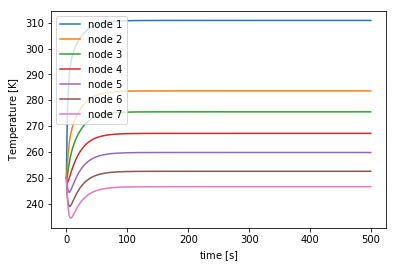

In [646]:
eq = Thermal_eq(n_nodes=n_nodes,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i,param_C=C_ij,param_c=c_i,param_R=R_ij)
eq.set_Q_in(1,get_Q1(n_steps,A,alpha,eps))
T_init = [250.,250.,250.,250.,250.,250.,250.,3.]
eq.solve_eq(T_init)
eq.plot_T(save=True)

### 節点7に入熱

now at 0 step


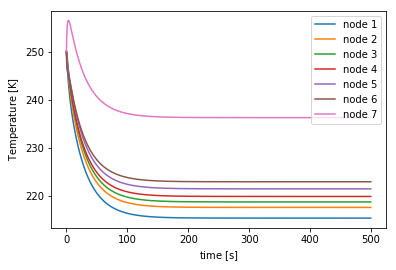

In [647]:
eq = Thermal_eq(n_nodes=n_nodes,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i,param_C=C_ij,param_c=c_i,param_R=R_ij)
eq.set_Q_in(7,get_Q7(n_steps,A,alpha,eps))
T_init = [250.,250.,250.,250.,250.,250.,250.,3.]
eq.solve_eq(T_init)
eq.plot_T(save=True)

### 横から入熱

now at 0 step


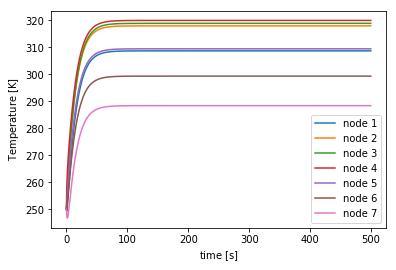

In [648]:
eq = Thermal_eq(n_nodes=n_nodes,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i,param_C=C_ij,param_c=c_i,param_R=R_ij)
eq.set_Q_in(2,get_Q2(n_steps,A,alpha,eps))
eq.set_Q_in(4,get_Q4(n_steps,A,alpha,eps))
eq.set_Q_in(6,get_Q6(n_steps,A,alpha,eps))
T_init = [250.,250.,250.,250.,250.,250.,250.,3.]
eq.solve_eq(T_init)
eq.plot_T(save=True)

# パターン2

In [906]:
### 基本定数 ###
G = 6.67e-11
r_e = 6378 #地球の半径[km]
M_e = 5.9724e24

### ミッション定数 ###
D = 1.
L2 = 1.
L4 = 0.7

H2 = L2/D
H4 = L4/D

A = [np.pi*D**2/4, np.pi*D*L2, np.pi*D**2/4, np.pi*D*L4, np.pi*D**2/4, 1e7]
alpha = [0.41, 0.16 ,0.25, 0.16, 0.34, 0.00]
eps =   [0.75, 0.66 ,0.85, 0.66, 0.55, 1.00]
eps[2] = eps[2]*0.9 #　放熱障害

n_nodes = 6
m_i = [30,30,30,30,30,100]
c_i = [0.8 for i in range(n_nodes)]
c_i[n_nodes-1] = 1e7
C_ij = (10 * np.array([
       [0.,1.,0.,0.,0.,0.],
       [1.,0.,1.,0.,0.,0.],
       [0.,1.,0.,1.,0.,0.],
       [0.,0.,1.,0.,1.,0.],
       [0.,0.,0.,1.,0.,0.],
       [0.,0.,0.,0.,0.,0.],
       ])).tolist()

F_12, F_22, F_13 = get_F_12(H2), get_F_22(H2), get_F_13(H2)
F_34, F_44, F_35 = get_F_12(H4), get_F_22(H4), get_F_13(H4)

R_ij = [[0., F_12*eps[0]*eps[1]*A[0]/2, F_13*eps[0]*eps[2]*A[0]/2, 0., 0., 0.5*eps[0]*eps[5]*A[0]],
     [F_12*eps[1]*eps[0]*A[1]/2, F_22*eps[1]*eps[1]*A[1]/2, F_12*eps[1]*eps[2]*A[1]/2, 0., 0., 0.5*eps[1]*eps[5]*A[1]],
     [F_13*eps[2]*eps[0]*A[2]/2, F_12*eps[2]*eps[1]*A[2]/2, 0., F_34*eps[2]*eps[3]*A[2]/2, F_35*eps[2]*eps[4]*A[2]/2, 0.],
     [0., 0., F_12*eps[3]*eps[2]*A[3]/2, F_22*eps[3]*eps[3]*A[3]/2, F_12*eps[3]*eps[4]*A[3]/2, 0.5*eps[3]*eps[5]*A[3]],
     [0., 0., F_13*eps[4]*eps[2]*A[4]/2, F_12*eps[4]*eps[3]*A[4]/2, 0., 0.],
     [0.,0.,0.,0.,0.,0.]]

r = 1200 + r_e
T_rev = 2*math.pi*math.sqrt((r*10**3)**3/G/M_e)

In [907]:
### 計算用の定数決定 ###
dt = 0.5
n_steps = 1000

## 入熱

In [908]:
def get_Q1(n_steps,A,alpha,eps):
    return ((alpha[0] * A[0] * 1 * Ps)*np.ones(n_steps)).tolist()
def get_Q2(n_steps,A,alpha,eps):
    return ((alpha[1] * A[1] * 1 / np.pi * Ps)*np.ones(n_steps)).tolist()
def get_Q4(n_steps,A,alpha,eps):
    return ((alpha[3] * A[3] * 1 / np.pi * Ps)*np.ones(n_steps)).tolist()
def get_Q5(n_steps,A,alpha,eps):
    return ((alpha[4] * A[4] * 1 * Ps)*np.ones(n_steps)).tolist()

### 節点1に入熱

now at 0 step


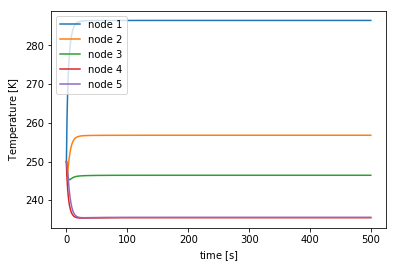

In [909]:
eq = Thermal_eq(n_nodes=n_nodes,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i,param_C=C_ij,param_c=c_i,param_R=R_ij)
eq.set_Q_in(1,get_Q1(n_steps,A,alpha,eps))
T_init = [250.,250.,250.,250.,250.,3.]
eq.solve_eq(T_init)
eq.plot_T(save=True,name='into_1')

### 節点5に入熱

now at 0 step


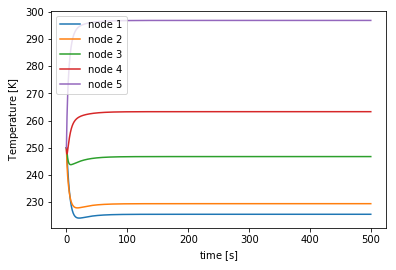

In [910]:
eq = Thermal_eq(n_nodes=n_nodes,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i,param_C=C_ij,param_c=c_i,param_R=R_ij)
eq.set_Q_in(5,get_Q5(n_steps,A,alpha,eps))
T_init = [250.,250.,250.,250.,250.,3.]
eq.solve_eq(T_init)
eq.plot_T(save=True,name='into_5')

### 横から入熱

now at 0 step


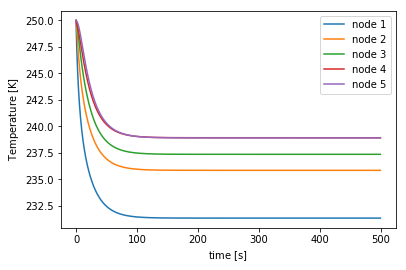

In [911]:
eq = Thermal_eq(n_nodes=n_nodes,n_steps=n_steps,dt=dt)
eq.set_params(param_m=m_i,param_C=C_ij,param_c=c_i,param_R=R_ij)
eq.set_Q_in(2,get_Q2(n_steps,A,alpha,eps))
eq.set_Q_in(4,get_Q4(n_steps,A,alpha,eps))
T_init = [250.,250.,250.,250.,250.,3.]
eq.solve_eq(T_init)
eq.plot_T(save=True,name='into_2_4')

In [912]:
eq.export_data_to_csv('temp')